In [355]:
import pandas as pd
import numpy as np
from numpy import ndarray
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from typing import List
import torch


class TimeSeriesDataset(Dataset):
    def __init__(self, data: ndarray, input_length: int = 384, output_length: int = 96):
        self.data = data
        self.input_length = input_length
        self.output_length = output_length

    def __len__(self):
        return len(self.data) - self.input_length - self.output_length + 1

    def __getitem__(self, idx):
        start = idx
        end = idx + self.input_length
        x = self.data[start:end]
        y = self.data[end : end + self.output_length]
        return (torch.tensor(x, dtype=torch.float32), 
                torch.tensor(y, dtype=torch.float32))


def load_and_process_data(
    filepath: str,
    target_columns: List[str],
    all_cols: bool = True,
    test_size: float = 0.2,
    normalize: bool = True,
):
    df = pd.read_csv(filepath)

    if all_cols:
        target_columns = df.columns[1:]

    data = df[target_columns].values

    if normalize:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)

    train_data, test_data = (
        data[: -int(len(data) * test_size)],
        data[-int(len(data) * test_size) :],
    )

    return train_data, test_data


def create_dataloaders(
    train_data: ndarray,
    test_data: ndarray,
    input_length: int = 384,
    output_length: int = 96,
    batch_size: int = 64,
):
    train_dataset = TimeSeriesDataset(train_data, input_length, output_length)
    test_dataset = TimeSeriesDataset(test_data, input_length, output_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


# Usage example
filepath = "../data/ETTh1.csv"
datetime_column = "date"
target_columns = ["OT", "LULL"] 
input_length = 384
output_length = 96
batch_size = 1

train_data, test_data = load_and_process_data(filepath, target_columns)
train_loader, test_loader = create_dataloaders(
    train_data, test_data, input_length, output_length, batch_size
)

In [338]:
train_data.shape

(773, 7)

In [356]:
train_loader.dataset[0][0].shape

torch.Size([384, 7])

In [357]:
train_loader.dataset[0][1].shape

torch.Size([96, 7])

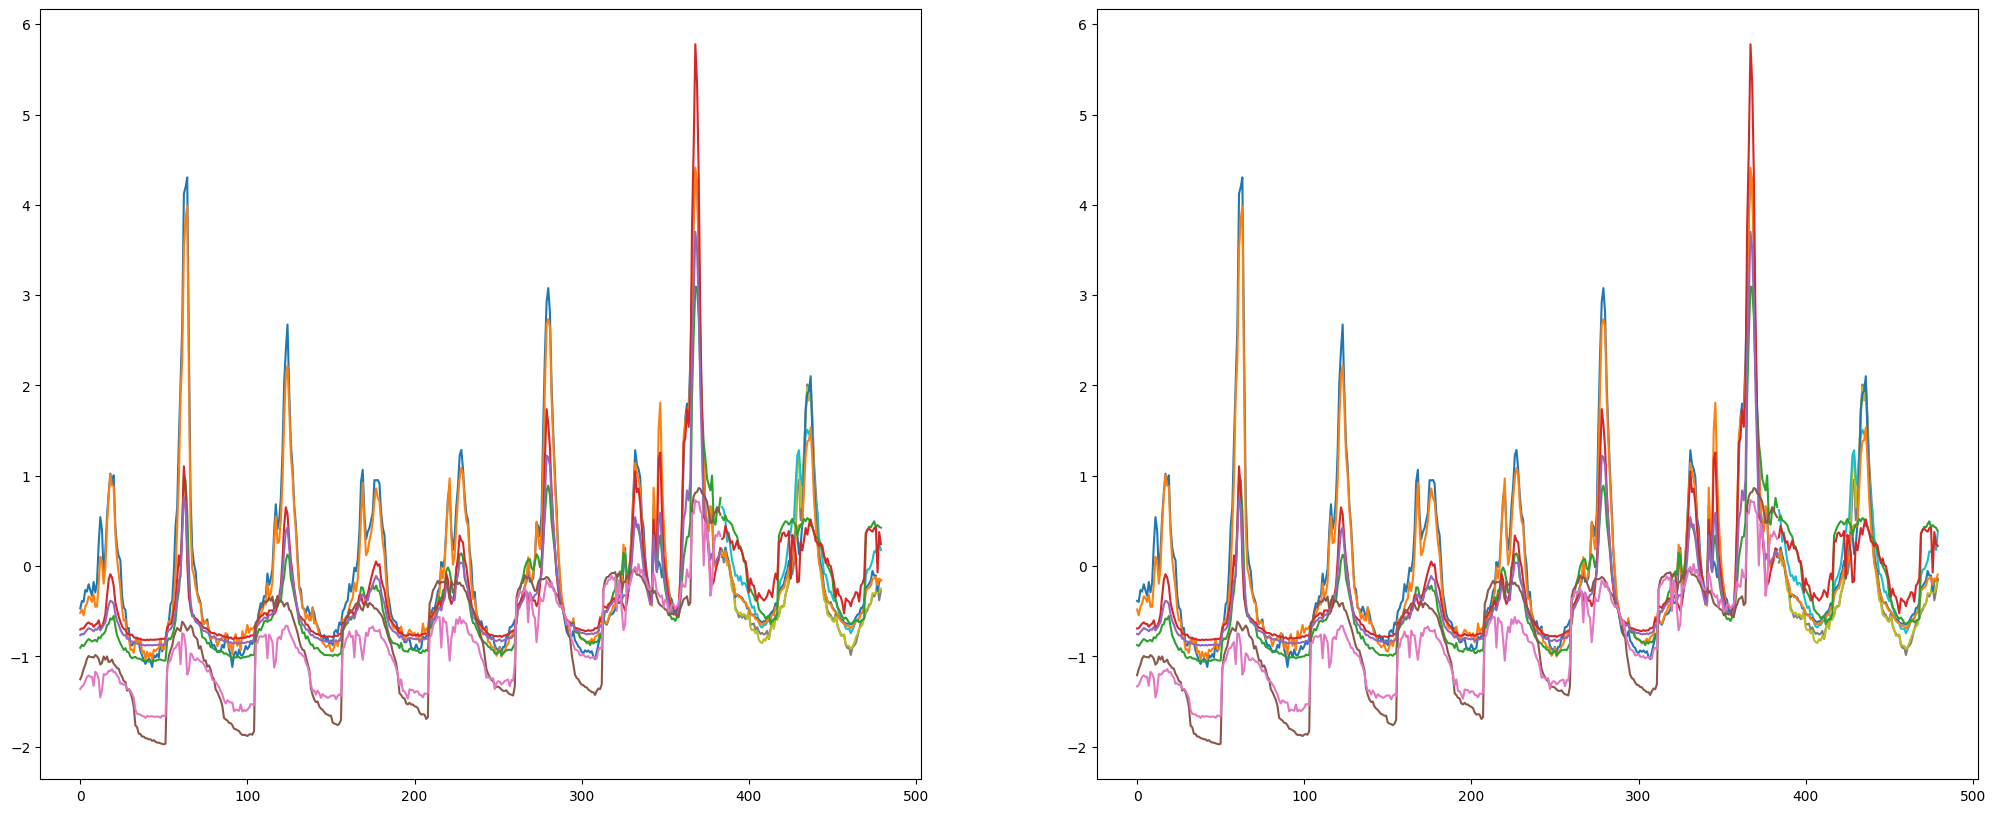

In [341]:
from matplotlib import pyplot as plt
def plot_batch(data_set, batch_size=1):
    fig, axs = plt.subplots(1, batch_size, figsize=(25, 10))
    for i in range(batch_size):
        input_seq = train_loader.dataset[i][0]
        pred_seq = train_loader.dataset[i][1]
        axs[i].plot(input_seq, label="input sequence")
        axs[i].plot(np.arange(len(input_seq), len(input_seq) + len(pred_seq)), pred_seq, label='output sequence')
        #axs[i].legend()
    plt.show()

plot_batch(train_data, 2)

In [37]:
import torch
import numpy as np



def augmentation(augment_time):
    if augment_time == 'batch':
        return BatchAugmentation()
    elif augment_time == 'dataset':
        return DatasetAugmentation()


class BatchAugmentation():
    def __init__(self):
        pass

    def freq_mask(self,x, y, rate=0.5, dim=1):
        xy = torch.cat([x,y],dim=1)
        xy_f = torch.fft.rfft(xy,dim=dim)
        m = torch.cuda.FloatTensor(xy_f.shape).uniform_() < rate
        freal = xy_f.real.masked_fill(m,0)
        fimag = xy_f.imag.masked_fill(m,0)
        xy_f = torch.complex(freal,fimag)
        xy = torch.fft.irfft(xy_f,dim=dim)
        return xy

    def freq_mix(self, x, y, rate=0.5, dim=1):
        xy = torch.cat([x,y],dim=dim)
        xy_f = torch.fft.rfft(xy,dim=dim)
        
        m = torch.cuda.FloatTensor(xy_f.shape).uniform_() < rate
        amp = abs(xy_f)
        _,index = amp.sort(dim=dim, descending=True)
        dominant_mask = index > 2
        m = torch.bitwise_and(m,dominant_mask)
        freal = xy_f.real.masked_fill(m,0)
        fimag = xy_f.imag.masked_fill(m,0)
        
        b_idx = np.arange(x.shape[0])
        np.random.shuffle(b_idx)
        x2, y2 = x[b_idx], y[b_idx]
        xy2 = torch.cat([x2,y2],dim=dim)
        xy2_f = torch.fft.rfft(xy2,dim=dim)

        m = torch.bitwise_not(m)
        freal2 = xy2_f.real.masked_fill(m,0)
        fimag2 = xy2_f.imag.masked_fill(m,0)

        freal += freal2
        fimag += fimag2

        xy_f = torch.complex(freal,fimag)
        
        xy = torch.fft.irfft(xy_f,dim=dim)
        return xy
    def noise(self,x,y,rate=0.05,dim=1):
        xy = torch.cat([x,y],dim=1)
        noise_xy = (torch.rand(xy.shape)-0.5) * 0.1
        xy = xy + noise_xy.cuda()
        return xy

    def noise_input(self,x,y,rate=0.05,dim=1):
        noise = (torch.rand(x.shape)-0.5) * 0.1
        x = x + noise.cuda()
        xy = torch.cat([x,y],dim=1)
        return xy
    
    def vFlip(self,x,y,rate=0.05,dim=1):
        # vertically flip the xy
        xy = torch.cat([x,y],dim=1)
        xy=-xy
        return xy
    
    def hFlip(self,x,y,rate=0.05,dim=1):
        # horizontally flip the xy
        xy = torch.cat([x,y],dim=1)
        # reverse the order of dim 1
        xy = xy.flip(dims=[dim])
        return xy
    
    def time_combination(self, x, y, rate=0.5, dim=1):
        xy = torch.cat([x,y],dim=dim)
        
        b_idx = np.arange(x.shape[0])
        np.random.shuffle(b_idx)
        x2, y2 = x[b_idx], y[b_idx]
        xy2 = torch.cat([x2,y2],dim=dim)

        xy = (xy+xy2)/2
        return xy
    
    def magnitude_warping(self, x, y, rate=0.5, dim=1):
        pass

    def linear_upsampling(self, x, y, rate=0.5, dim=1):
        xy = torch.cat([x,y],dim=dim)
        original_shape=xy.shape
        # randomly cut a segment from xy the length should be half of it
        # generate a random integer from 0 to the length of xy
        start_point = np.random.randint(0,original_shape[1]//2)

        xy = xy[:,start_point:start_point+original_shape[1]//2,:]
        
        # interpolate the xy to the original_shape
        xy=xy.permute(0,2,1)
        xy = torch.nn.functional.interpolate(xy, scale_factor=2, mode='linear')
        xy=xy.permute(0,2,1)
        return xy


class DatasetAugmentation():
    def __init__(self):
        pass

    def freq_dropout(self, x, y, dropout_rate=0.2, dim=0, keep_dominant=True):
        x, y = torch.from_numpy(x), torch.from_numpy(y)

        xy = torch.cat([x,y],dim=0)
        xy_f = torch.fft.rfft(xy,dim=0)

        m = torch.FloatTensor(xy_f.shape).uniform_() < dropout_rate

        
        # amp = abs(xy_f)
        # _,index = amp.sort(dim=dim, descending=True)
        # dominant_mask = index > 5
        # m = torch.bitwise_and(m,dominant_mask)

        freal = xy_f.real.masked_fill(m,0)
        fimag = xy_f.imag.masked_fill(m,0)
        xy_f = torch.complex(freal,fimag)
        xy = torch.fft.irfft(xy_f,dim=dim)

        x, y = xy[:x.shape[0],:].numpy(), xy[-y.shape[0]:,:].numpy()
        return x, y

    def freq_mix(self, x, y, x2, y2, dropout_rate=0.2):
        x, y = torch.from_numpy(x), torch.from_numpy(y)

        xy = torch.cat([x,y],dim=0)
        xy_f = torch.fft.rfft(xy,dim=0)
        m = torch.FloatTensor(xy_f.shape).uniform_() < dropout_rate
        amp = abs(xy_f)
        _,index = amp.sort(dim=0, descending=True)
        dominant_mask = index > 2
        m = torch.bitwise_and(m,dominant_mask)
        freal = xy_f.real.masked_fill(m,0)
        fimag = xy_f.imag.masked_fill(m,0)
        

        x2, y2 = torch.from_numpy(x2), torch.from_numpy(y2)
        xy2 = torch.cat([x2,y2],dim=0)
        xy2_f = torch.fft.rfft(xy2,dim=0)

        m = torch.bitwise_not(m)
        freal2 = xy2_f.real.masked_fill(m,0)
        fimag2 = xy2_f.imag.masked_fill(m,0)

        freal += freal2
        fimag += fimag2

        xy_f = torch.complex(freal,fimag)
        xy = torch.fft.irfft(xy_f,dim=0)
        x, y = xy[:x.shape[0],:].numpy(), xy[-y.shape[0]:,:].numpy()
        return x, y